<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/Markov_process_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/

In [4]:
!pip install scipy

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def equilibrium_distribution(p_transition):
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    b = np.transpose(np.array([0] * n_states + [1]))
    p_eq = np.linalg.solve(
        a=np.transpose(A).dot(A),
        b=np.transpose(A).dot(b)
    )
    return p_eq

In [3]:
from scipy.stats import multinomial
from typing import List

def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [5]:
p_init = np.array([0.1, 0.8, 0.1])
p_transition = np.array(
    [[0.90, 0.05, 0.05],
     [0.01, 0.90, 0.09],
     [0.07, 0.03, 0.9]])

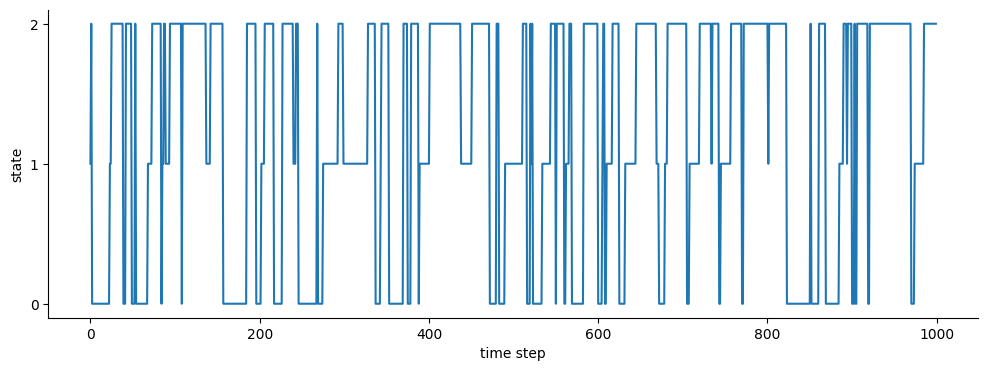

In [8]:
import seaborn as sns

states = markov_sequence(p_init, p_transition, sequence_length=1000)
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1, 2])
sns.despine()

In [9]:
from scipy.stats import norm

def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    emissions = []
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
    return emissions

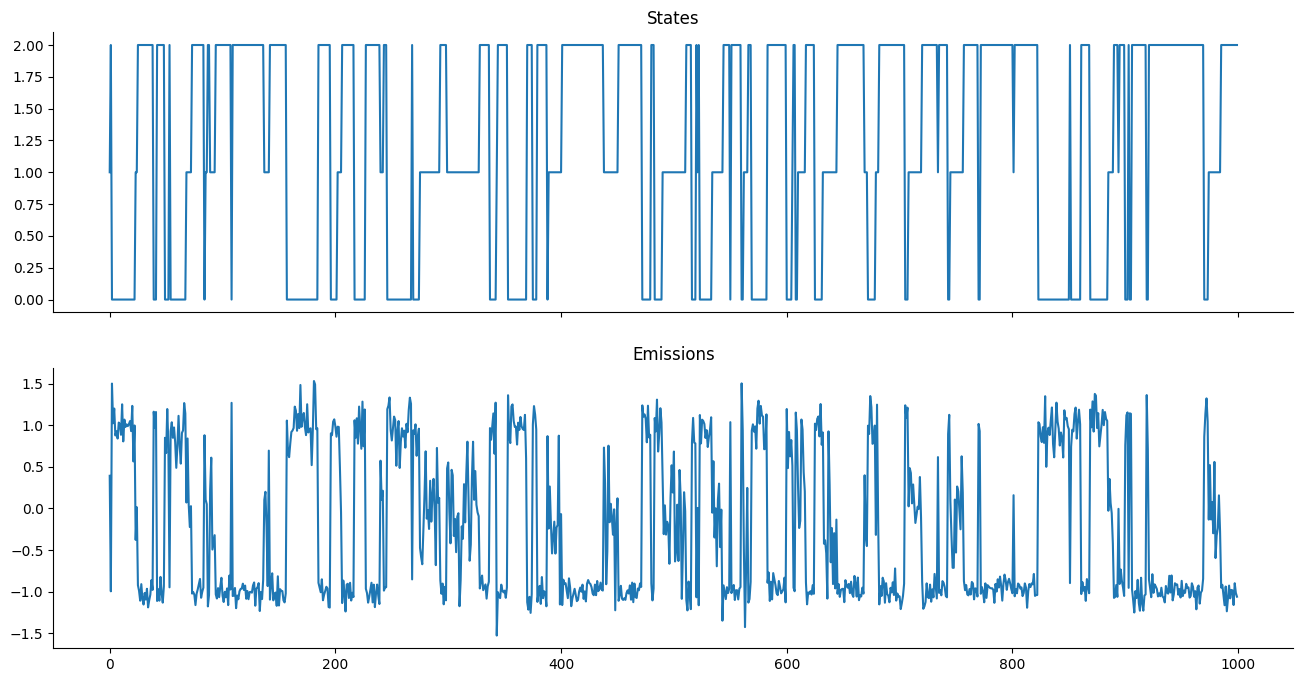

In [10]:
gaussian_ems = gaussian_emissions(states, mus=[1, 0, -1], sigmas=[0.2, 0.5, 0.1])

def plot_emissions(states, emissions):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    sns.despine();

plot_emissions(states, gaussian_ems)